# Sensitivity analysis

Sensitivity analysis (SA) studies the uncertainty in the output of a model. It attempts to measure this uncertainty in the output by making small (known) changes in the inputs, in the process identifying which parameter/set of parameters has the greatest influence. This increases understanding of the relationship between input and output, which in turn can help us find errors in the model. Another purpose of SA is model simplification; model inputs that have little to no effect on the output can be fixed to specific values.

In this notebook we aim to familiarise you with OFAT and Sobol SA. We will use Mesa's BatchRunner throughout the notebook and Sobol SA will be done through use of [SALib](https://github.com/SALib/SALib).

First, we install the package and test if we can import it.

Now we'll import everything required for this notebook...

In [1]:
%matplotlib inline
from IPython.display import clear_output
from SALib.sample import saltelli
from model import FIFA_Simulation
from manager import Manager
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output

# The model

SA is only usefull if we can apply it to something. Instead of having you make another model, we will use a predator-prey model that you are familiar with; the "wolf-sheep predation model". Specifically, [the wolf-sheep model provided in the examples provided by Mesa](https://github.com/projectmesa/mesa/tree/master/examples/wolf_sheep). You might recognise parts of it that were used as inspiration for the first notebook.

From the description:

''A simple ecological model, consisting of three agent types: wolves, sheep, and grass. The wolves and the sheep wander around the grid at random. Wolves and sheep both expend energy moving around, and replenish it by eating. Sheep eat grass, and wolves eat sheep if they end up on the same grid cell.

If wolves and sheep have enough energy, they reproduce, creating a new wolf or sheep (in this simplified model, only one parent is needed for reproduction). The grass on each cell regrows at a constant rate. If any wolves and sheep run out of energy, they die.''

The model can be found in the folder 'wolf_sheep/'. If you are interested, you can read through the code. You can even use:

`mesa runserver`

...to view the model in action.

# OFAT SA
One Factor at A Time (OFAT or OFaaT) SA is a method of testing the output variance of inputs one at a time. 

We will show you how to change only one variable at the time and how to plot the results. The model we use has default parameters for each of the variables, which makes this fairly easy.

In [2]:
# We define our variables and bounds
problem = {
    'num_vars': 3,
    'names': ['mu', 'sigma', 'earnings_ratio'],
    'bounds': [[25000000, 50000000], [2500000, 5000000], [(1 / 20), (1 / 5)]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 2
max_steps = 10
distinct_samples = 5

# Set the outputs (STILL NEED TO IMPLEMENT THIS IN ACTUAL MODEL)
model_reporters = {"Manager assets": lambda m: m.schedule.get_manager_assets(),
             "Manager reputation": lambda m: m.schedule.get_manager_reputation()}

data = {}



In [5]:
for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    batch = BatchRunner(FIFA_Simulation, 
                        max_steps=max_steps,
                        iterations=replicates,
                        variable_parameters={var: samples},
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()

0it [00:00, ?it/s]

Transforming fifa data took --- 0.05310463905334473 seconds ---


10it [03:30, 22.19s/it]
10it [03:24, 20.26s/it]
10it [03:25, 20.54s/it]


In [10]:
import pickle
pickle.dump( data, open( "fifa.p", "wb" ) )

In [10]:



import pickle
# if you don't want to run experiment, just have data
data = None
with open('fifa.p', 'rb') as handle:
    data = pickle.load(handle)

data['mu']

,mu,Run,Manager assets,Manager reputation
0,25000000.0,0,"{15: 47729950.27163215, 7: 22674456.651366606,...","{15: 8, 7: 6, 5: 6, 3: -16, 6: 42, 0: 10, 10: ..."
1,25000000.0,1,"{15: 69153708.03102174, 11: 34752849.96509316,...","{15: 36, 11: 0, 9: 8, 17: 60, 6: -24, 16: 4, 7..."
2,31250000.0,2,"{15: 45183193.578900635, 12: 67208219.44264255...","{15: -24, 12: -18, 0: 50, 16: -22, 17: -12, 1:..."
3,31250000.0,3,"{11: 33619194.54616693, 0: 2544011.6377976714,...","{11: 48, 0: 8, 8: -10, 6: -8, 7: 10, 15: -4, 1..."
4,37500000.0,4,"{3: 19377460.826668527, 4: 816061.2128284113, ...","{3: 70, 4: 16, 8: 12, 7: -6, 0: 2, 5: -60, 14:..."
5,37500000.0,5,"{1: 43550283.50518508, 11: 22130671.691694677,...","{1: -28, 11: 50, 2: 18, 17: -62, 3: 2, 5: 2, 4..."
6,43750000.0,6,"{16: 1611026.3740939207, 15: 97438102.49551709...","{16: -8, 15: -34, 7: -2, 5: -4, 14: 8, 11: 32,..."
7,43750000.0,7,"{16: 1471192.8891770835, 3: 42093199.72712605,...","{16: -2, 3: -26, 1: 18, 2: -18, 8: 12, 7: 6, 4..."
8,50000000.0,8,"{3: 5782434.914946106, 13: 41105211.75456845, ...","{3: -12, 13: -20, 17: -30, 9: -28, 8: -12, 11:..."
9,50000000.0,9,"{0: 6253936.457366172, 17: 44721811.85542642, ...","{0: -32, 17: 4, 6: 8, 10: 24, 9: -14, 8: -6, 3..."


Now that we have the data, we can plot it! First show the influence of the variable on sheep, then on wolves.

####################################
Plotting param: Manager assets, averages for 5 runs


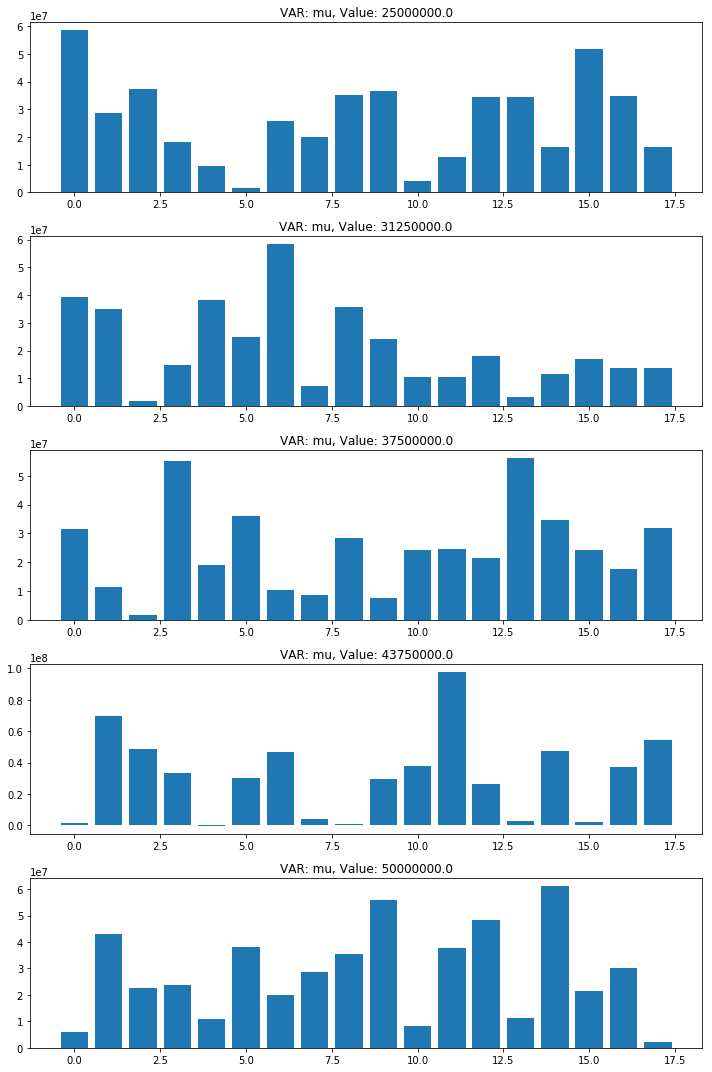

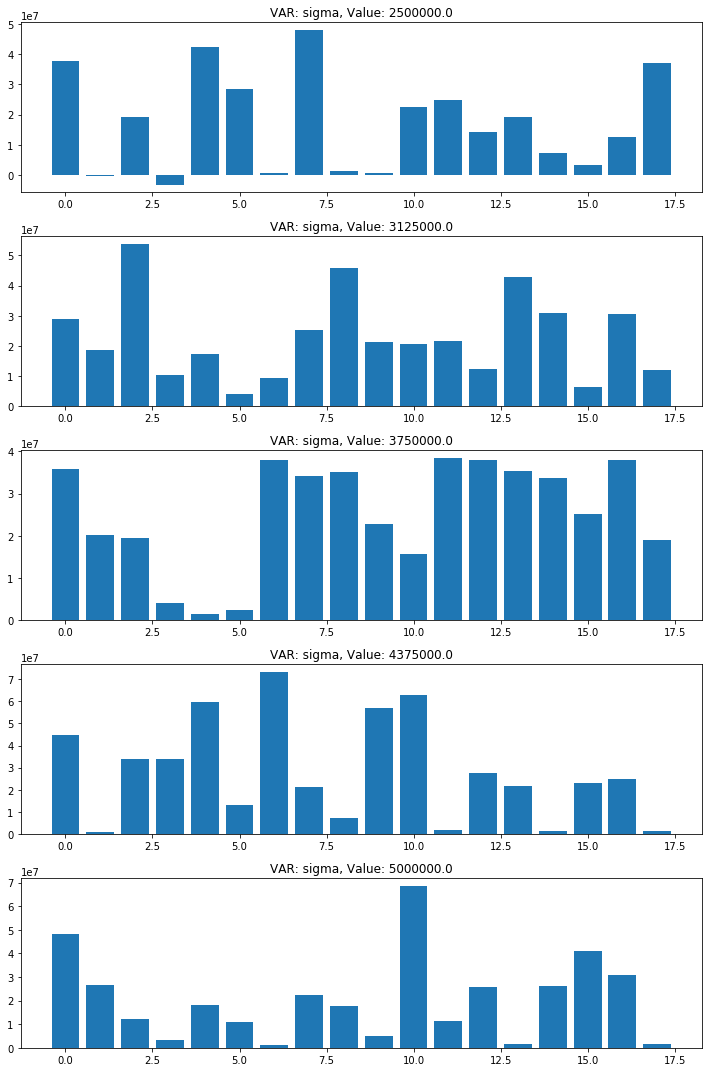

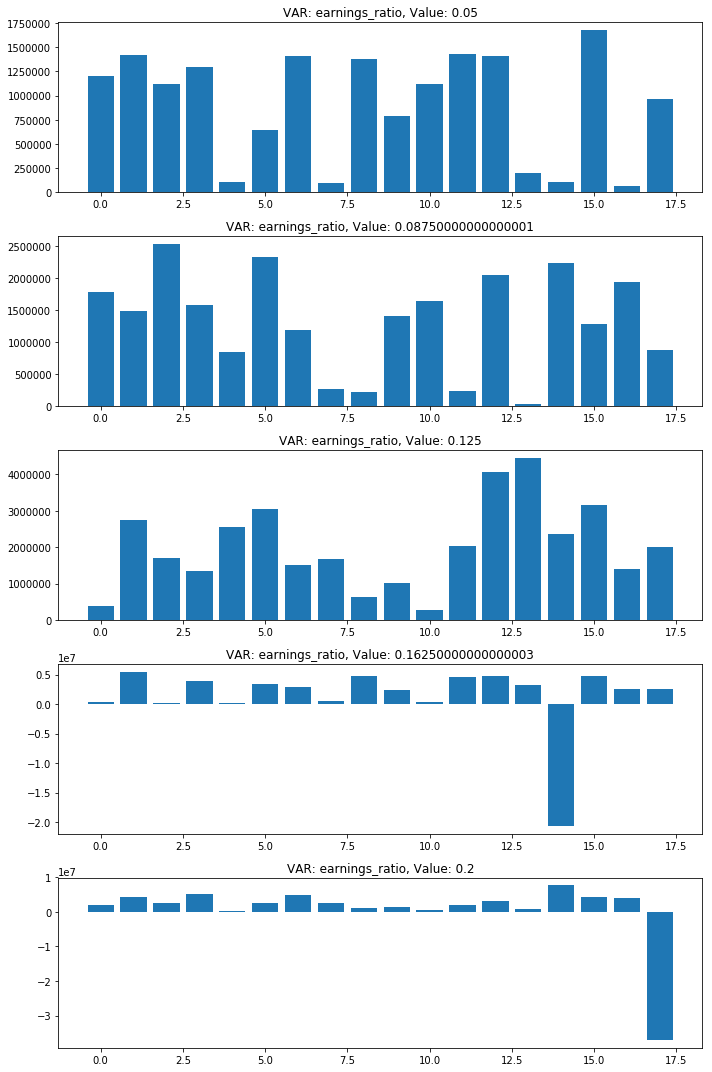

####################################
Plotting param: Manager reputation, averages for 5 runs


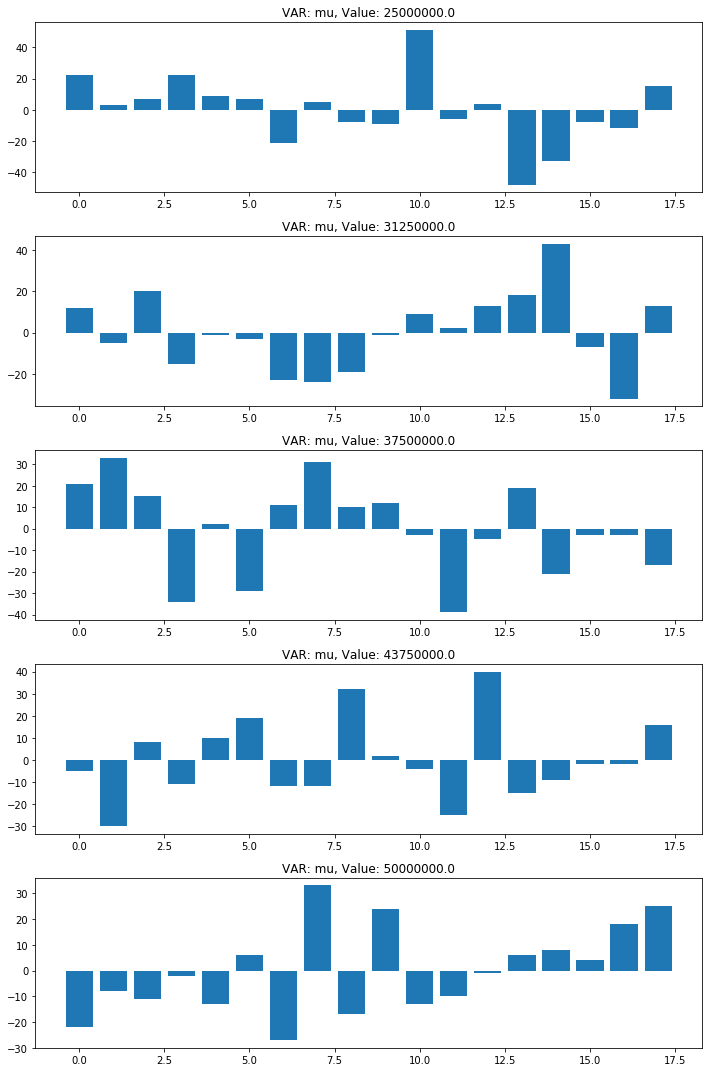

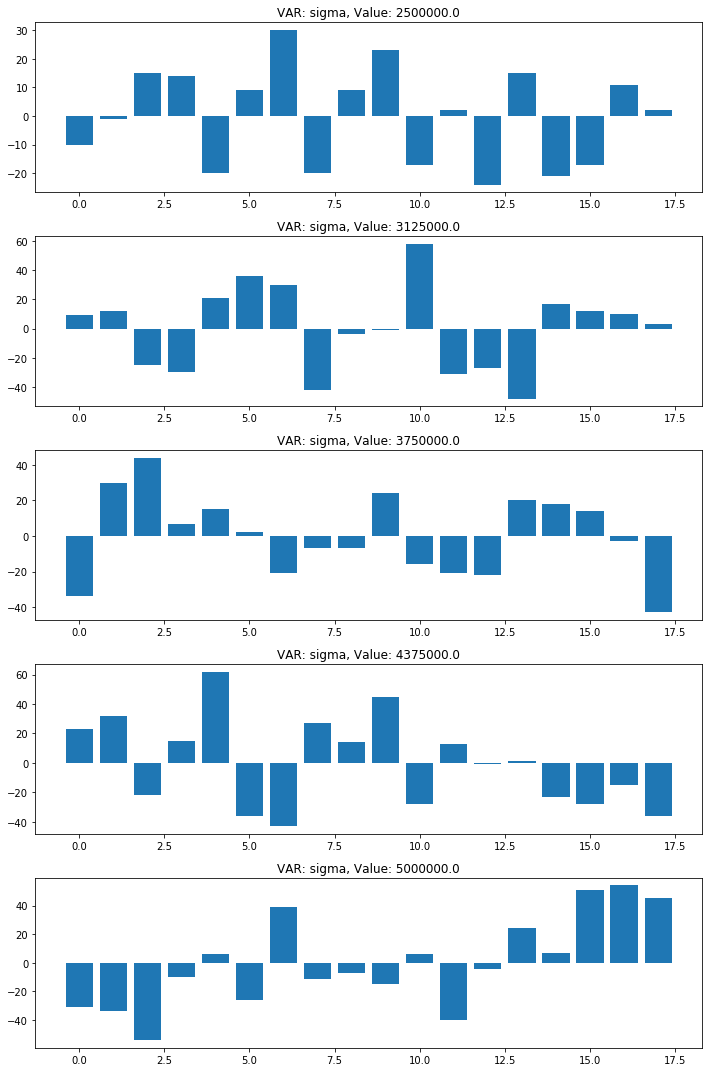

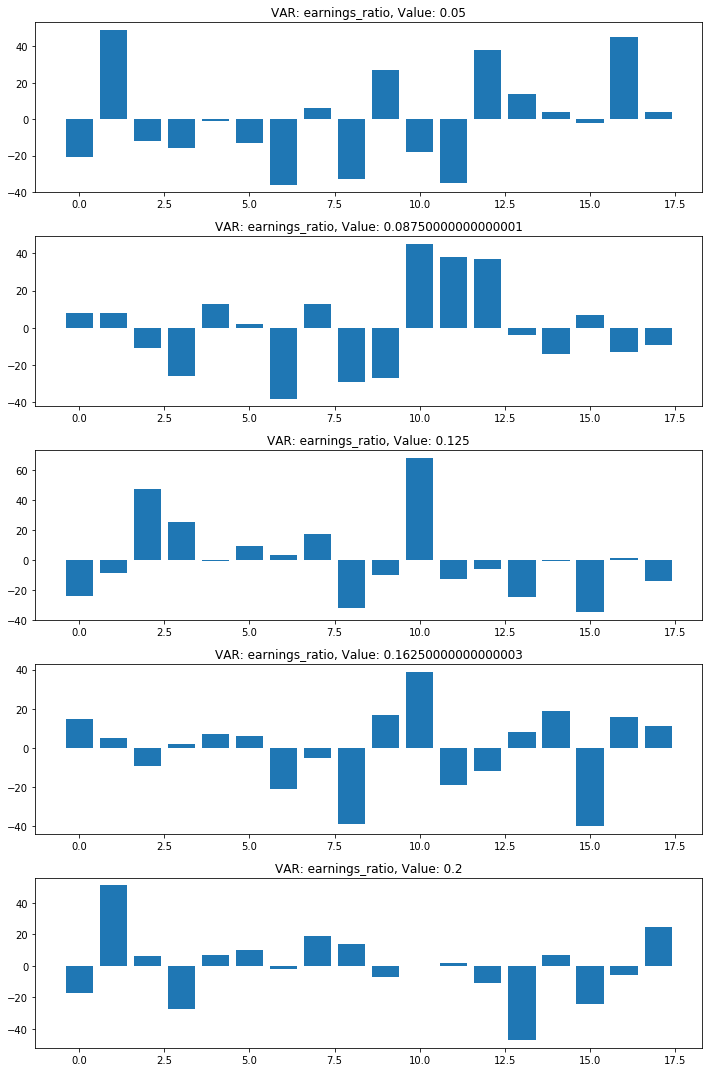

In [12]:
#Not finished, the code has to be modified to work properly
def mean_managers(data):
    
    count = 0
    out = None
    out2 = None
    for index, row in data.iterrows():
        count+=1
        if out is None:
            out = pd.DataFrame(list(row['Manager assets'].values()))
            out2 = pd.DataFrame(list(row['Manager reputation'].values()))
            
        else:
            out = out.add(pd.DataFrame(list(row['Manager assets'].values())))
            out2 = out2.add(pd.DataFrame(list(row['Manager reputation'].values())))
    out = out/count
    out2 = out2/count
    var = data.columns[0]
    
    #print(out[0].tolist())
    #print("##########")
    out =  pd.Series({var: data.iloc[0][var],'Manager assets':out[0].tolist(), 
                      'Manager reputation' :out2[0].tolist()})
    #print(out)
    return out


def plot_param_var_conf(df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    #print(var)
    #print(df)
    #print(df.iloc[0]['Manager assets'])
    mean = df.groupby(var, as_index=False).apply(mean_managers)
    #print(mean)
    
    
    f, axs = plt.subplots(mean.shape[0], figsize=(10, 15))
    
    for index, row in mean.iterrows():
        axs[index].bar(list(range(len(row[param]))),row[param])
        axs[index].set_title("VAR: " + str(var) + ", Value: " + str(row[var]))
    f.tight_layout()
    
def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    
    print("####################################")
    print("Plotting param: {}, averages for 5 runs".format(param))
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(data[var], var, param, i)

for param in ('Manager assets', 'Manager reputation'):
    plot_all_vars(data, param)
    plt.show()

# Sobol SA

Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087)) is a global SA method that determines the contribution of each input parameter or a combination of parameters and their interaction to the overall output variance. OFAT, while it is easier to implement (and certainly is less thought-intensive), has a couple of downsides.

1. OFAT requires a large amount of runs to get accurate results
2. OFAT cannot estimate interactions of combinations of inputs
3. OFAT can miss optimal settings of factors

Sobol can find higher order interactions, but still requires a large amount of runs.

### Getting the data

Before we can start analysing the model, we will have to sample our data. There are multiple methods for sampling included in SALib, but since we're using Sobol, we will use Saltelli sampling for this. 

The following code shows how you could collect data for the "wolf-sheep" model.

In [3]:
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 2
max_steps = 10
distinct_samples = 5

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)

# READ NOTE BELOW CODE
batch = BatchRunner(FIFA_Simulation, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

count = 0
for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals[2] = int(vals[2])

        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
    
data = batch.get_model_vars_dataframe()

100.00% done


Note that even though we use the BatchRunner provided by Mesa, we do not use its full capabilities. Normally, you would set all parameters properly (at line 25) and then run the batchrunner with `batch.run_all()`. However, the batchrunner will then proceed to run every possible combination of the variables you have passed it. We already have the combinations (samples) we need, because we got those from SALib.

Preferably, you would want to save the results as a csv so you can load them more easily when analysing your results. 

Printing the data shows (a part of) our results:

In [5]:
print(data)

import pickle
pickle.dump( data, open( "sobol.pickle", "wb" ) )

              mu         sigma  earnings_ratio  Run  \
0   3.049316e+07  2.741699e+06               0    0   
1   4.191895e+07  2.741699e+06               0    1   
2   3.049316e+07  3.200684e+06               0    2   
3   3.049316e+07  2.741699e+06               0    3   
4   3.049316e+07  3.200684e+06               0    4   
5   4.191895e+07  2.741699e+06               0    5   
6   4.191895e+07  3.200684e+06               0    6   
7   4.191895e+07  3.200684e+06               0    7   
8   4.299316e+07  3.991699e+06               0    8   
9   2.941895e+07  3.991699e+06               0    9   
10  4.299316e+07  4.450684e+06               0   10   
11  4.299316e+07  3.991699e+06               0   11   
12  4.299316e+07  4.450684e+06               0   12   
13  2.941895e+07  3.991699e+06               0   13   
14  2.941895e+07  4.450684e+06               0   14   
15  2.941895e+07  4.450684e+06               0   15   
16  4.924316e+07  3.366699e+06               0   16   
17  4.8168

In [8]:
import pickle
# if you don't want to run experiment, just have data
data = None
with open('sobol.pickle', 'rb') as handle:
    data = pickle.load(handle)
data

,mu,sigma,earnings_ratio,Run,Manager assets,Manager reputation
0,3.049316e+07,2.741699e+06,0,0,"{1: 598587.3798624203, 4: 184836.35983589292, ...","{1: -6, 4: -36, 15: 40, 6: 48, 17: 2, 5: -20, ..."
1,4.191895e+07,2.741699e+06,0,1,"{8: 895.7142275124788, 9: 1768639.675625436, 1...","{8: -24, 9: -34, 1: -12, 7: 16, 15: 54, 2: -18..."
2,3.049316e+07,3.200684e+06,0,2,"{13: 1303957.9669323266, 16: 1568564.646910965...","{13: -36, 16: -14, 6: 26, 9: -10, 0: -30, 5: -..."
3,3.049316e+07,2.741699e+06,0,3,"{2: 1274955.3963548504, 7: 1219296.0288660415,...","{2: -64, 7: -32, 13: 10, 3: 6, 15: 16, 5: -12,..."
4,3.049316e+07,3.200684e+06,0,4,"{1: 775612.7980350852, 4: 710677.4384814948, 0...","{1: 14, 4: -46, 0: -12, 15: 26, 6: 12, 7: -10,..."
5,4.191895e+07,2.741699e+06,0,5,"{8: 128682.89324145764, 16: 601030.9784872383,...","{8: 0, 16: -22, 17: -6, 7: -24, 4: -2, 15: -10..."
6,4.191895e+07,3.200684e+06,0,6,"{15: 9666.763121597469, 3: 1135457.364552781, ...","{15: 30, 3: 12, 2: -18, 13: 24, 12: -4, 0: 6, ..."
7,4.191895e+07,3.200684e+06,0,7,"{11: 27010.814284414053, 2: 359726.90432370454...","{11: 10, 2: 18, 13: -16, 6: -8, 4: -14, 8: -10..."
8,4.299316e+07,3.991699e+06,0,8,"{14: 1731113.0112039, 7: 1621804.812201947, 8:...","{14: 4, 7: -36, 8: -2, 10: 2, 6: 4, 2: 6, 1: -..."
9,2.941895e+07,3.991699e+06,0,9,"{0: 3901.9033908583224, 10: 77681.53371385485,...","{0: -14, 10: -20, 16: -18, 3: 44, 6: 32, 14: 1..."


As you can see we have 800 distinct results. One sample from saltelli-sampling results in $2^3=8$ different combinations. (We have 3 variables, and we take 2 distinct values per sample per variable. For more details, take a look at [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087)). Since we take 10 samples, we get 80 combinations. We repeat each of these combinations 10 times, resulting in 800 results.

We only consider 2 outputs in this example; the amount of sheep and wolves at the end of the simulation. Can you think of more outputs?

### Analyzing

Now we can use the `analyze()` method provided by SALib that performs Sobol analysis. 

In [9]:
Si_mu = sobol.analyze(problem, data['mu'].as_matrix(), print_to_console=True)
Si_sigma = sobol.analyze(problem, data['sigma'].as_matrix(), print_to_console=True)

Parameter S1 S1_conf ST ST_conf
mu 0.697945 0.855388 0.697945 0.737625
sigma 0.000000 0.000000 0.000000 0.000000
earnings_ratio 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
mu sigma 0.000000 0.488157
mu earnings_ratio 0.000000 0.488157
sigma earnings_ratio 0.000000 0.000000
Parameter S1 S1_conf ST ST_conf
mu 0.000000 0.000000 0.000000 0.000000
sigma 1.294658 0.607886 1.224124 0.624571
earnings_ratio 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
mu sigma 0.000000 0.000000
mu earnings_ratio 0.000000 0.000000
sigma earnings_ratio -0.141068 0.729255


/home/lukas/Documents/agendBasedModelling/agend_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/lukas/Documents/agendBasedModelling/agend_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


This is not very insightfull. Let's make a function that can plot this.

In [10]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

We'll first plot 1st, 2nd, and total-order sensitivity for the output variable 'Sheep', then for 'Wolves'. 

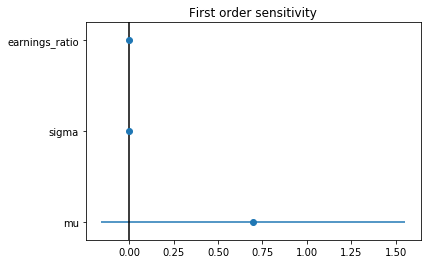

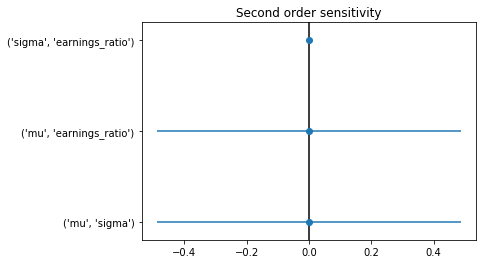

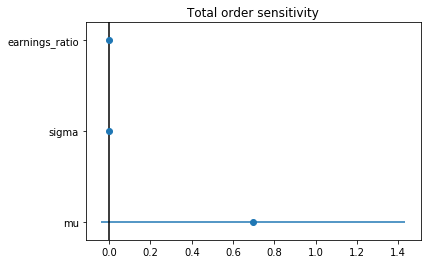

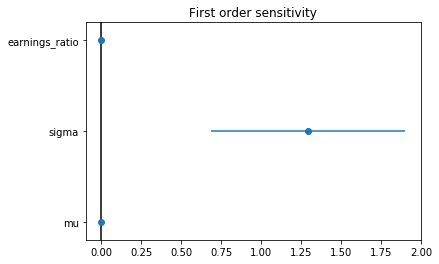

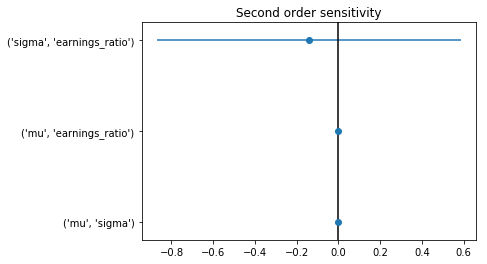

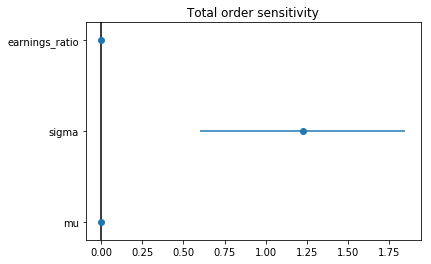

In [12]:
for Si in (Si_mu, Si_sigma):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # Second order
    plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()